## MARTIN LORENZO R. VENTURA 
# Probset 2
ECON 138 (2022-05199)

In [1]:
pip install rasterstats

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mapclassify

Note: you may need to restart the kernel to use updated packages.


In [5]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from rasterstats import zonal_stats
from matplotlib.font_manager import FontProperties


## South Africa: Hydrodams and Population Density
- Objective: Replicate Figure 2 from Mettetal (2019), substituting river gradient with population density.

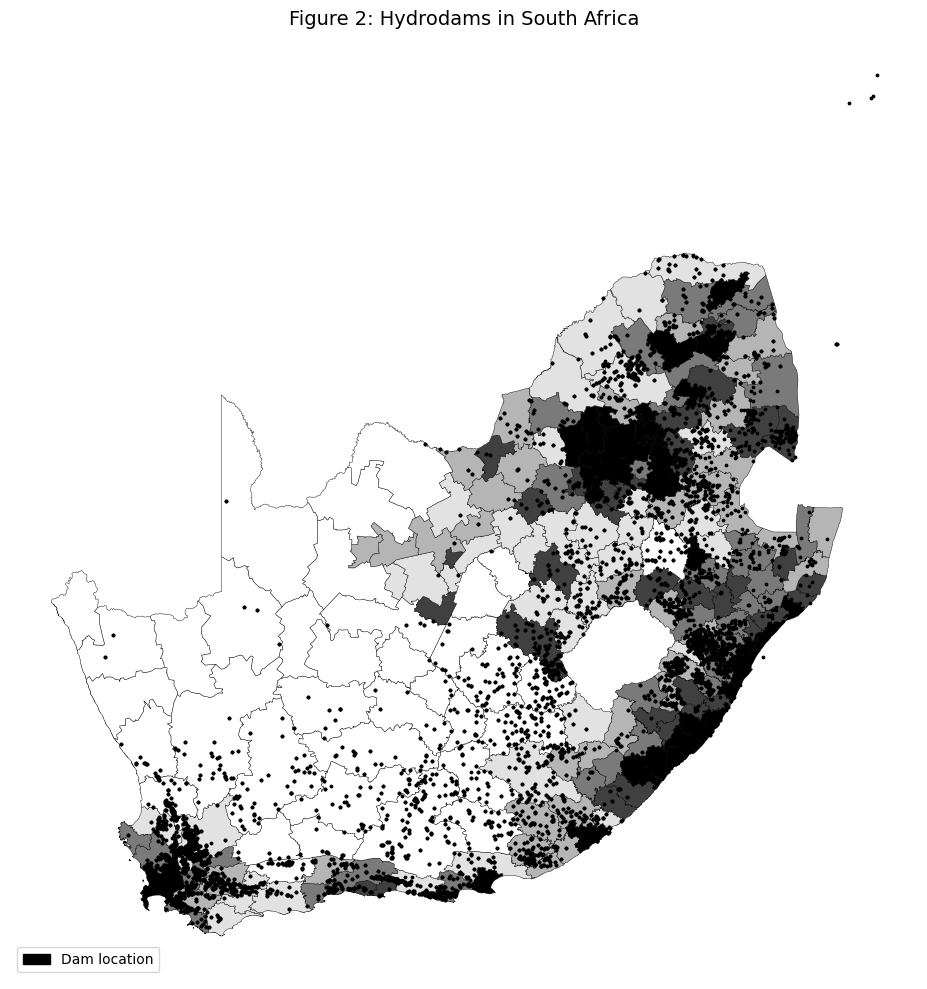

In [49]:
# Load shapefile with population density or district data
sa_map_path = r'C:\Users\Hp\Downloads\geo_mapping_problem_set\data\south_africa\SA_MDB_Local_Municipal_Boundary_2018\MDB_Local_Municipal_Boundary_2018.shp'
sa_map = gpd.read_file(sa_map_path)

# --- Load dam data ---
excel_path = r'C:\Users\Hp\Downloads\geo_mapping_problem_set\data\south_africa\Dams_south_africa.xlsx'
pop_raster_path = r'C:\Users\Hp\Downloads\geo_mapping_problem_set\data\south_africa\zaf_pd_2020_1km.tif'
dams_df = pd.read_excel(excel_path)

# Convert from DMS to decimal degrees
dams_df['Latitude'] = - (dams_df['Latitude deg'] + dams_df['Lat min'] / 60 + dams_df['Lat sec'] / 3600)
dams_df['Longitude'] = dams_df['Longitude deg'] + (dams_df['Long min'] / 60) + (dams_df['Long sec'] / 3600)

# Create GeoDataFrame for dams
dams_gdf = gpd.GeoDataFrame(dams_df, geometry=gpd.points_from_xy(dams_df['Longitude'], dams_df['Latitude']), crs='EPSG:4326')
dams_gdf = dams_gdf.to_crs(sa_map.crs)  

# --- Calculate zonal stats for population density ---
# 1. Calculate area in km² using an equal-area projection
sa_map_proj = sa_map.to_crs(epsg=6933)  # Equal-area projection (World Cylindrical Equal Area)
sa_map['area_km2'] = sa_map_proj.geometry.area / 1e6  # m² to km²

# 2. Calculate sum of population inside each polygon from raster
stats_sum = zonal_stats(sa_map, pop_raster_path, stats=['sum'], geojson_out=False)
sa_map['population'] = [stat['sum'] if stat['sum'] is not None else 0 for stat in stats_sum]

# 3. Calculate population density = population / area
sa_map['pop_density'] = sa_map['population'] / sa_map['area_km2']

# 4. Log transform population density to handle wide range (add small constant to avoid log(0))
sa_map['pop_density_log'] = np.log10(sa_map['pop_density'] + 1e-3)



import matplotlib.patches as mpatches

# --- Plotting (Grayscale with Dams on Top) ---
fig, ax = plt.subplots(figsize=(12, 10))
fig.patch.set_facecolor('white')

# Plot population density with grayscale tones
sa_map.plot(
    column='pop_density_log',
    cmap='Greys',
    scheme='quantiles',
    k=6,
    linewidth=0.3,
    edgecolor='black',
    legend=False,
    ax=ax,
    alpha=1.0
)

# Plot dams as black dots
dams_gdf.plot(
    ax=ax,
    color='black',
    markersize=3,
    alpha=1,
    zorder=10
)

# Add custom legend for dam locations
dam_patch = mpatches.Patch(color='black', label='Dam location')
ax.legend(handles=[dam_patch], loc='lower left', fontsize=10, frameon=True)

# Title and clean up
ax.set_title("Figure 2: Hydrodams in South Africa", fontsize=14)
ax.set_axis_off()

# Save and show
plt.tight_layout()
os.makedirs('output', exist_ok=True)
plt.savefig(os.path.join('output', 'replicated_sa_map.png'), dpi=300, bbox_inches='tight')
plt.show()


For this part, I started by loading the shapefile of South Africa’s local municipalities, which served as the base map. Then I loaded the dam dataset from an Excel file, along with the population density raster from WorldPop. Since the dam coordinates were in DMS format, I had to convert them into decimal degrees so I could properly map them. After that, I turned the dam data into a GeoDataFrame and reprojected it to match the coordinate system of the SA map. For the population data, 

I projected the map into an equal-area CRS (EPSG:6933) to get accurate area measurements, then calculated the area of each municipality in square kilometers. I used zonal statistics to sum up the population inside each boundary from the raster data, and computed population density by dividing the population by area. To make the density values more manageable for visualization, I applied a log transformation (with a small constant added to avoid log(0)). Finally, I plotted the log-transformed population density in grayscale, and overlaid the dam points as small black dots. I added a simple legend and a title, and saved the figure for later use. Overall, it was a straightforward process, but getting the CRS and formatting right took a bit of tweaking.

## ETHIOPIA

In [33]:
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

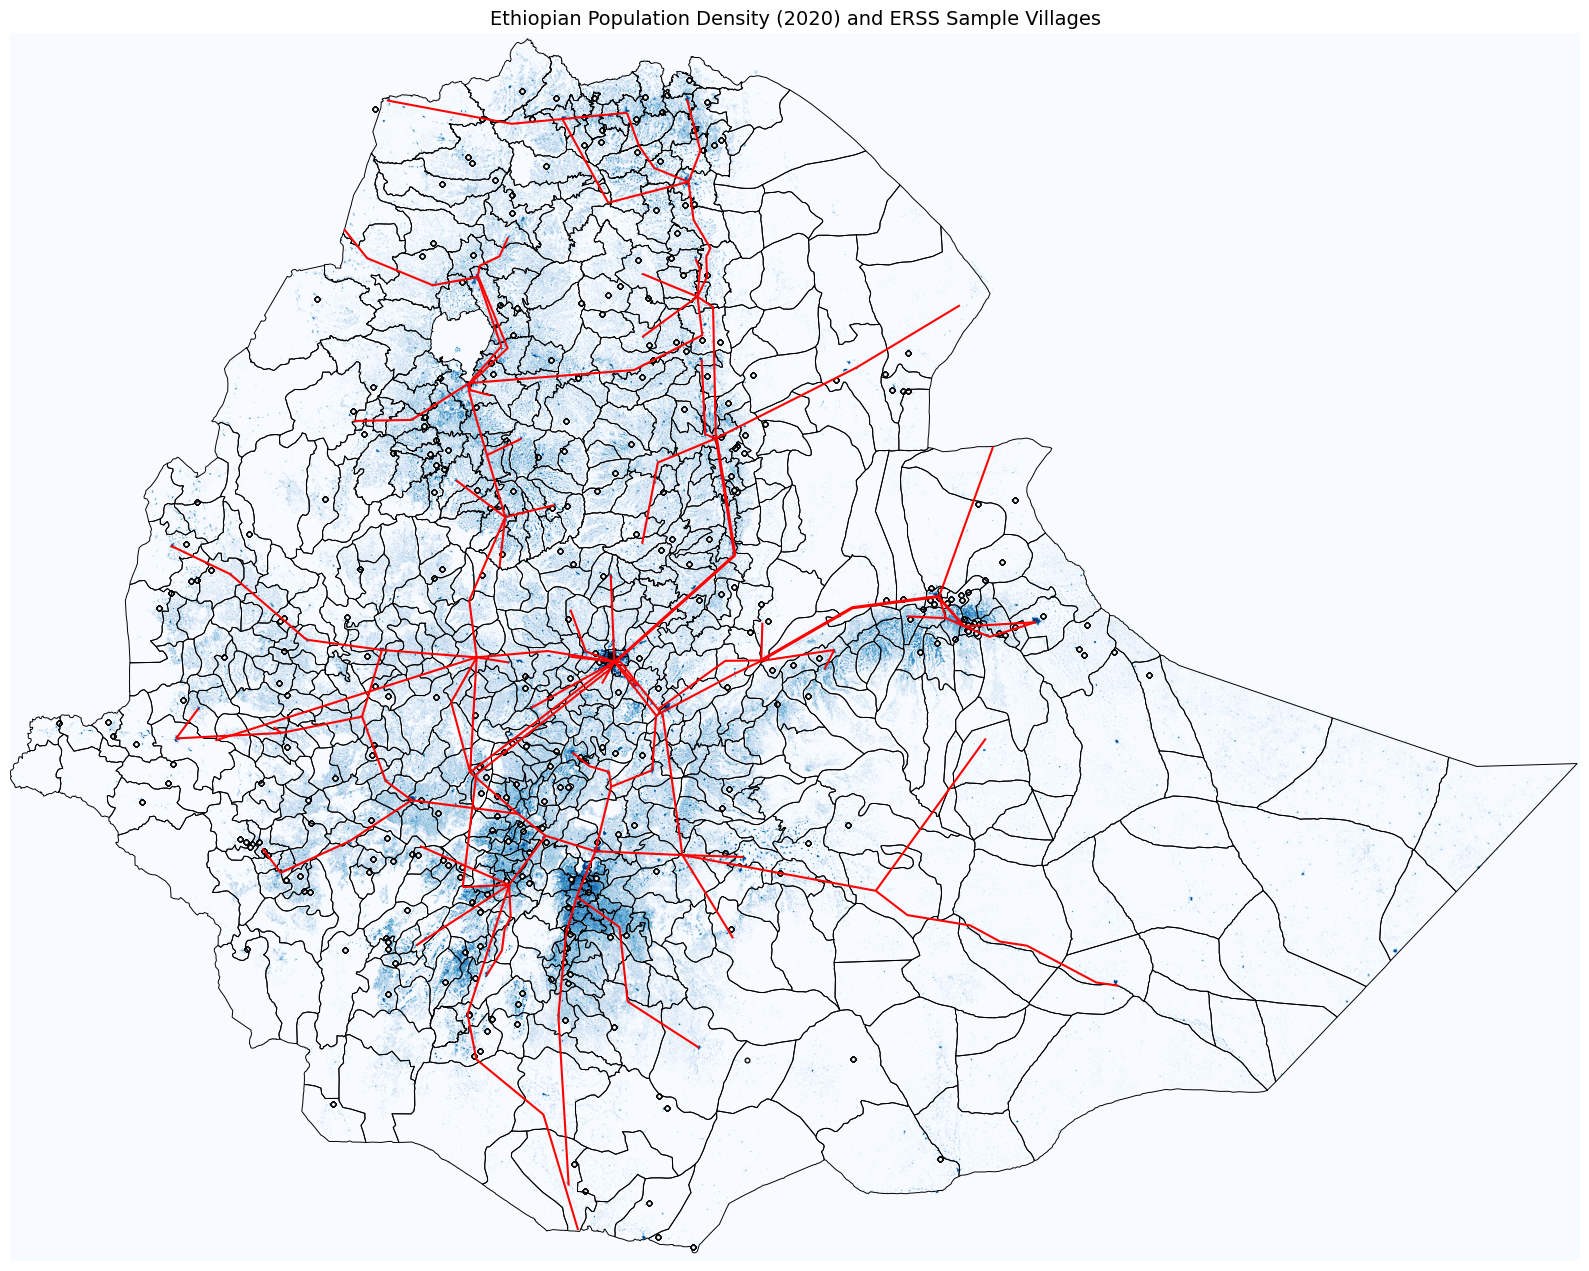

In [65]:
# === Load data ===
grid_shapefile = r'C:\Users\Hp\Downloads\geo_mapping_problem_set\data\ethiopia\ethiopia-electricity-transmission-network\Ethiopia Electricity Transmission Network.shp'
raster_path = r'C:\Users\Hp\Downloads\geo_mapping_problem_set\data\ethiopia\eth_ppp_2020_constrained.tif'
admin_shapefile = r'C:\Users\Hp\Downloads\geo_mapping_problem_set\data\ethiopia\Ethiopia_AdminBoundaries-shp'
village_csv = r'C:\Users\Hp\Downloads\geo_mapping_problem_set\data\ethiopia\pub_eth_householdgeovariables_y1.csv'

# Load raster
raster = rasterio.open(raster_path)
pop_data = raster.read(1)
extent = [raster.bounds.left, raster.bounds.right, raster.bounds.bottom, raster.bounds.top]

# Load shapefiles
admin_gdf = gpd.read_file(admin_shapefile).to_crs(raster.crs)
grid_gdf = gpd.read_file(grid_shapefile).to_crs(raster.crs)

# Load and convert village points
villages_df = pd.read_csv(village_csv)
villages_gdf = gpd.GeoDataFrame(
    villages_df,
    geometry=gpd.points_from_xy(villages_df["LON_DD_MOD"], villages_df["LAT_DD_MOD"]),
    crs="EPSG:4326"
).to_crs(raster.crs)

# === Plot ===
fig, ax = plt.subplots(figsize=(16, 13))

# Background raster
show(pop_data, ax=ax, cmap="Blues", extent=extent)

# Admin boundaries
admin_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=0.7)

# Transmission grid
grid_gdf.plot(ax=ax, color="red", linewidth=1.5)

# Sample villages
villages_gdf.plot(ax=ax, color="white", edgecolor="black", markersize=10, alpha=0.8)

# Title and layout
ax.set_title("Ethiopian Population Density (2020) and ERSS Sample Villages", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

In this part, I worked with data from Ethiopia to visualize population density, sample villages, and the electricity transmission grid all in one map. First, I loaded all the necessary files shapefiles for the admin boundaries and the transmission network, a raster for 2020 population data, and a CSV for the village locations. I read the population raster using rasterio and grabbed the data array and its extent so I could plot it later. I also loaded the shapefiles and reprojected everything to match the raster’s coordinate system to avoid any weird misalignments. For the villages, I converted the coordinates from the CSV into a GeoDataFrame and reprojected that too. Then came the plotting part: I used the raster as the background in blue shades to show population density, outlined the admin boundaries in black, and overlaid the grid lines in red to show where the electricity lines run. Finally, I plotted the villages as white dots with black edges to make them pop out a bit more. I added a title and made sure the layout was neat. I had to edit this several times because the raster wouldnt show up the first few times but overall i think its pretty accurate.

## Figure 10: Roadmap of Vietnam 

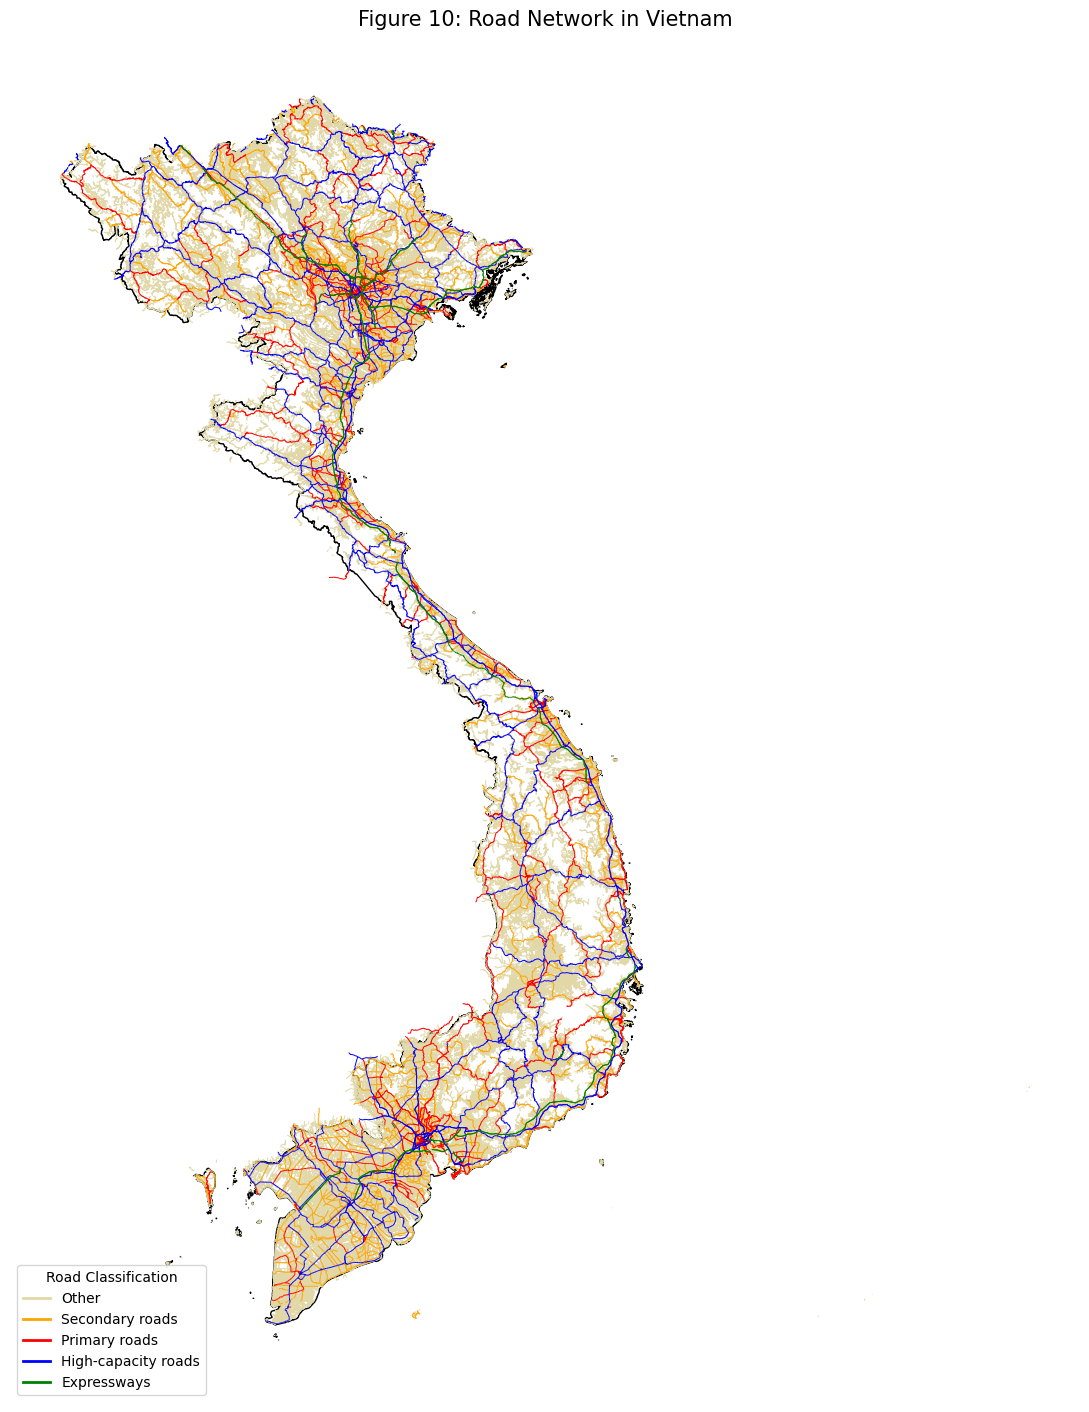

In [70]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# === Load shapefiles ===
road_path = r'C:\Users\Hp\Downloads\geo_mapping_problem_set\data\vietnam\gis_osm_roads_free_1.shp'
boundary_path = r'C:\Users\Hp\Downloads\geo_mapping_problem_set\data\vietnam\gadm41_VNM_0.shp'

roads_gdf = gpd.read_file(road_path)
vnm_boundary = gpd.read_file(boundary_path)

# === Classify road types ===
road_type_map = {
    'Expressways': ['motorway', 'motorway_link'],
    'High-capacity roads': ['trunk', 'trunk_link'],
    'Primary roads': ['primary', 'primary_link'],
    'Secondary roads': ['secondary', 'secondary_link'],
    'Other': ['tertiary', 'tertiary_link', 'residential', 'unclassified', 'road']
}

def get_category(fclass):
    for category, types in road_type_map.items():
        if fclass in types:
            return category
    return 'Other'

roads_gdf['type_group'] = roads_gdf['fclass'].apply(get_category)

# === Define visual style for each category ===
style_dict = {
    'Expressways': 'green',
    'High-capacity roads': 'blue',
    'Primary roads': 'red',
    'Secondary roads': 'orange',
    'Other': '#e2d8a7'  # muted yellow
}

# === Plot ===
fig, ax = plt.subplots(figsize=(11, 15))
vnm_boundary.boundary.plot(ax=ax, linewidth=1, color='black')

# Plot roads in reverse priority so major ones sit on top
layer_order = ['Other', 'Secondary roads', 'Primary roads', 'High-capacity roads', 'Expressways']
for category in layer_order:
    subset = roads_gdf[roads_gdf['type_group'] == category]
    subset.plot(ax=ax, linewidth=0.7, color=style_dict[category], label=category)

# Custom legend with consistent labels
legend_elements = [
    Line2D([0], [0], color=style_dict[key], lw=2, label=key)
    for key in layer_order
]

# Final touches
ax.set_title("Figure 10: Road Network in Vietnam", fontsize=15)
ax.legend(handles=legend_elements, title='Road Classification', loc='lower left')
ax.set_axis_off()

plt.tight_layout()
plt.show()

This part took a bit more patience than usual because the shapefile for Vietnam’s roads was really heavy it took so long to load that I wasn’t sure if the code was actually working or just stuck.                                                                                                            

I started by loading in two shapefiles: one for the road network and another for the country’s boundary. The road data had a lot of specific types, so I grouped them into broader categories like expressways, high-capacity roads, and so on. I used a simple function to map each road to a category based on its fclass, which made the data a lot easier to work with. After that, I set up a color scheme to visually separate the road types. When plotting, I made sure to draw the less important roads first so that the major roads would be visible on top. I also added a custom legend to keep everything clear. Overall, the logic was straightforward, but the slow loading time made the process feel a bit longer than expected (It took so long i still dont get why).

## Figure 1: Brazil's Capital and Main Road Infrastructure.

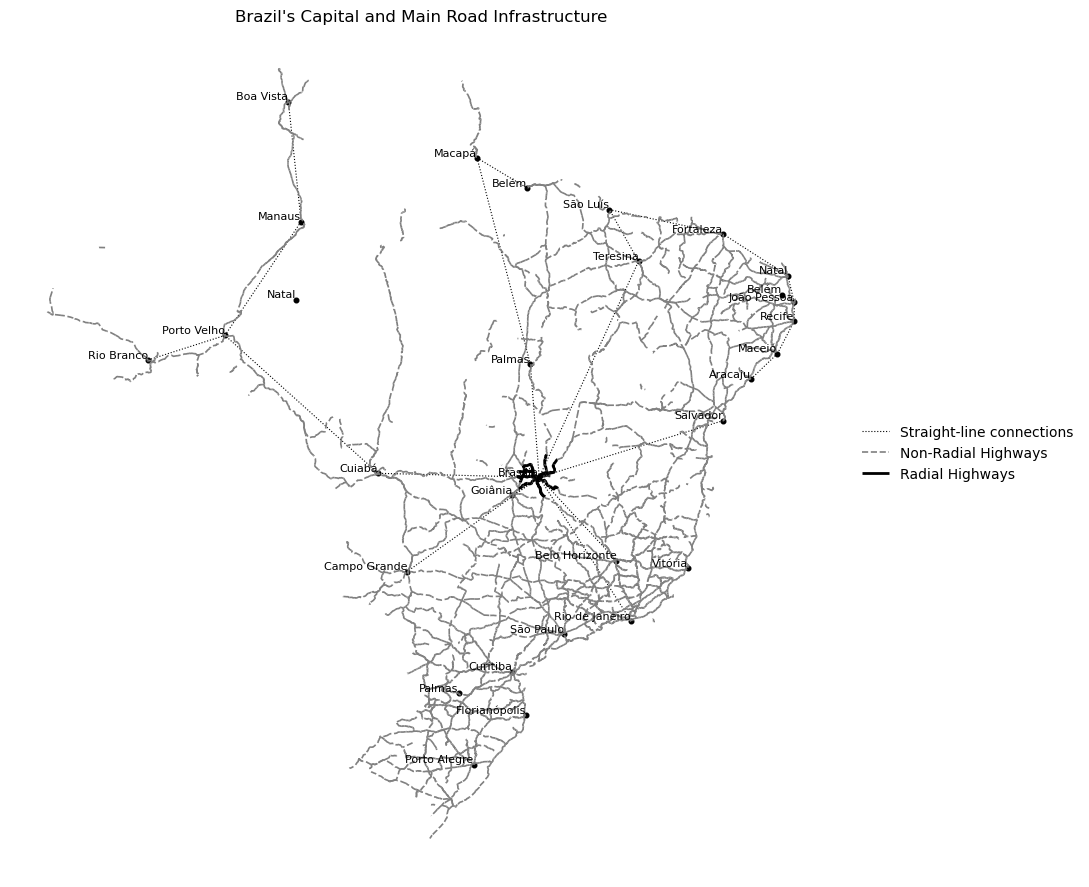

In [59]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# --- Load roads shapefile ---
roads_path = r"C:\Users\Hp\Downloads\geo_mapping_problem_set\data\brazil\highways_2010_prj.shp"
roads_gdf = gpd.read_file(roads_path).to_crs("EPSG:4326")

# --- Load cities CSV and filter Brazil ---
cities_csv_path = r"C:\Users\Hp\Downloads\geo_mapping_problem_set\data\brazil\worldcities.csv"
cities = pd.read_csv(cities_csv_path)
cities = cities[cities['country'] == 'Brazil']

# --- Select main cities ---
main_cities = [
    
    'Recife',
    'Curitiba',
    'Porto Alegre',
    'Goiânia',
    'Belém',
    'Manaus',
    'Cuiabá',
    'Campo Grande',
    'Natal',
    'São Luís',
    'Aracaju',
    'Maceió',
    'João Pessoa',
    'Brasília',
    'São Paulo',
    'Rio de Janeiro',
    'Salvador',
    'Belo Horizonte',
    'Fortaleza',
    'Teresina',
    'Macapá',
    'Boa Vista',
    'Palmas',
    'Florianópolis',
    'Vitória',
    'Rio Branco',
    'Porto Velho'
]
cities = cities[cities['city'].isin(main_cities)]

# --- Convert cities to GeoDataFrame ---
cities_gdf = gpd.GeoDataFrame(
    cities,
    geometry=gpd.points_from_xy(cities['lng'], cities['lat']),
    crs="EPSG:4326"
)

# --- Define Brasília buffer for radial roads ---
brasilia_point = cities_gdf[cities_gdf['city'] == 'Brasília'].geometry.iloc[0]
brasilia_buffer = brasilia_point.buffer(1)  # buffer of 1 degree

# --- Classify roads as radial or non-radial ---
roads_gdf['road_class'] = roads_gdf.geometry.apply(
    lambda geom: 'Radial' if geom.intersects(brasilia_buffer) else 'Non-Radial'
)

# --- Define manual MST edges ---
city_pairs = [
    ('Brasília', 'Goiânia'), ('Brasília', 'Rio de Janeiro'), ('Brasília', 'Salvador'),
    ('Brasília', 'Belo Horizonte'), ('Brasília', 'Campo Grande'), ('Brasília', 'Cuiabá'),
    ('Brasília', 'Teresina'), ('Brasília', 'Palmas'), ('Palmas', 'Macapá'),
    ('Macapá', 'Belém'), ('Teresina', 'São Luís'), ('São Luís', 'Fortaleza'),
    ('Fortaleza', 'Natal'), ('Natal', 'João Pessoa'), ('João Pessoa', 'Recife'),
    ('Recife', 'Maceió'), ('Maceió', 'Aracaju'), ('Cuiabá', 'Porto Velho'),
    ('Porto Velho', 'Manaus'), ('Manaus', 'Boa Vista'), ('Porto Velho', 'Rio Branco')
]

lines = []
for city1, city2 in city_pairs:
    point1 = cities_gdf[cities_gdf['city'] == city1].geometry.values[0]
    point2 = cities_gdf[cities_gdf['city'] == city2].geometry.values[0]
    lines.append(LineString([point1, point2]))

mst_gdf = gpd.GeoDataFrame(geometry=lines, crs="EPSG:4326")

# --- Plotting ---
fig, ax = plt.subplots(figsize=(11, 13))
fig.patch.set_facecolor('white')

# Plot MST connections
mst_gdf.plot(ax=ax, color='black', linestyle=':', linewidth=0.8, label='Straight-line connections')

# Plot roads by type
roads_gdf[roads_gdf['road_class'] == 'Non-Radial'].plot(ax=ax, color='gray', linestyle='--', linewidth=1.2, label='Non-Radial Highways')
roads_gdf[roads_gdf['road_class'] == 'Radial'].plot(ax=ax, color='black', linewidth=2, label='Radial Highways')

# Plot capital cities
cities_gdf.plot(ax=ax, color='black', markersize=11)

# Annotate cities
for _, row in cities_gdf.iterrows():
    x, y = row.geometry.x, row.geometry.y
    ax.text(x, y, row['city'], fontsize=8, ha='right', va='bottom')

# Final touches
ax.set_title("Brazil's Capital and Main Road Infrastructure", fontsize=12)
ax.axis('off')
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.tight_layout()
plt.show()

This one actually took a bit of back and forth because I kept tweaking it to make it look closer to the original. the roads were just kinda everywhere and I couldn’t tell which ones were supposed to be the big “radial” ones from Brasília. So I added that buffer circle around Brasília to help me flag the highways that actually connect to it, which felt more true to the idea they were going for. Even then, I had to play around with the width and color of the roads at first everything looked way too cluttered or too faint to even see, so I kept adjusting the styling like the thickness and dash patterns.

The fake connections between cities (the straight lines) were another part that needed a bunch of trial and error. I manually listed all the city pairs like a minimum spanning tree kind of setup, and had to redo a couple of them ‘cause they looked off or overlapped weirdly with the real roads. The cities themselves also needed some labeling fixes some names were getting cut off or overlapping each other, so I messed with the text alignment and font size until it was readable. I still preferred doing this compared to the vietnam one overall.